# Overlap in Lexical and Literary Vocabulary

Comparing the vocabulary of Old Babylonian lexical texts (from Nippur) and the vocabulary of the Sumerian literary corpus as represented in [ETCSL](http://etcsl.orinst.ox.ac.uk/).

## 0 Preparation 
In order to run this notebook, parse the [DCCLT](http://oracc.org/dcclt) data with the Extended ORACC Parser (2.3.3) and the [ETCSL](http://etcsl.orinst.ox.ac.uk) data with the ETCSL Parser (2.4).

In [1]:
%matplotlib inline
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import tqdm
import re
import zipfile
import json

### 0.1 Read ETCSL Data Files
Open the file `alltexts.csv` which contains all the [ETCSL](http://etcsl.orinst.ox.ac.uk) and read the data into a `Pandas`DataFrame. Each row is a word from [ETCSL](http://etcsl.orinst.ox.ac.uk/) in lemmatized format, according to [ePSD2](http://build-oracc.museum.upenn.edu/epsd2) standards. Only Sumerian words are kept; Akkadian glosses, for instance, are removed.

In [2]:
file = "../2_4_Data_Acquisition_ETCSL/Output/alltexts.csv"
etcsl = pd.read_csv(file, keep_default_na=False)
etcsl = etcsl.loc[etcsl["lang"].str.contains("sux")]  # throw out non-Sumerian words

### 0.2 Lemmas
Create a lemmas column and lowercase all lemmas.

The `lemmas` column is created by combining Citation Form (`cf`), Guide Word (`gw`) and Part of Speech (`pos`). The Pandas `apply()` function applies a function to every row (`axis = 1`) or column (`axis = 0`) of a dataframe. The function is defined here as a so-called `lambda` function (a temporary function). It is a simple addition of the strings of the `cf`, `gw`, and `pos` columns (with `[` and `]` as separators), so that a single lemma now looks like `lugal[king]N`. The `lambda` function has one condition: if there is no Citation Form (column `cf` equals the empty string) the contents of the column `form` are taken, followed by `NA]NA]`. The absence of a Citation Form implies that the word was not lemmatized (perhaps an unknown or a broken word). The field `form` contains the raw transliteration - the result may be `x-ra-bi[NA]NA`.

If the field `form` is empty (which happens, for instance, where a horizontal in the text is noted), however, this results in the `lemma` entry `NA[NA]`. In those case the value of `lemma` is turned into the empty string with a conditional list comprehension.

For the current analysis we will use *lemmatized* forms for the comparison between literary and lexical vocabulary. The unlemmatized forms, therefore, are of little importance here. We need to keep them, for now, because we will also compare *sequences* of lemmas. Premature removal of unlemmatized forms would result in false positives. 

In [3]:
etcsl["lemma"] = etcsl.apply(lambda r: (r["cf"] + '[' + r["gw"] + ']' + r["pos"]) 
                            if r["cf"] != '' else r['form'] + '[NA]NA', axis=1)
etcsl['lemma'] = [lemma if not lemma == '[NA]NA' else '' for lemma in etcsl['lemma'] ] 
# kick out empty forms
etcsl["lemma"] = etcsl["lemma"].str.lower()

### 0.3 Read Lexical Data

Essentially following the same process as in the preceding cells. The code assumes that the [DCCLT](http://oracc.org/dcclt) data are parsed with the Extended ORACC Parser (2.3.3) and that the resulting file is called `parsed.csv` in the directory `2_3_DataAcquisition_ORACC/output`. If this is not the case, please adjust the file name in code below.

In [4]:
file = "../2_3_Data_Acquisition_ORACC/output/parsed.csv"
lexical = pd.read_csv(file, keep_default_na=False)
lexical = lexical.loc[lexical["lang"].str.contains("sux")]

In [5]:
lexical["lemma"] = lexical.apply(lambda r: (r["cf"] + '[' + r["gw"] + ']' + r["pos"]) 
                            if r["cf"] != '' else r['form'] + '[NA]NA', axis=1)
lexical['lemma'] = [lemma if not lemma == '[NA]NA' else '' for lemma in lexical['lemma'] ] 
# kick out empty forms
lexical["lemma"] = lexical["lemma"].str.lower()

Sign lists (which belong to the broader category of lexical lists) list cuneiform signs with pronunciation glosses and sometimes with Akkadian translation, sign name, and other information. For the current purposes we *only* need the Sumerian word that is represented by the entry. We remove lemmas that derive from the pronunciation glosses and the signs themselves. Sign names and Akkadian translations are already removed, because they are in Akkadian.

The Pandas function `isin()` compares the contents of a field with a list and returns a boolean (`True` or `False`). In this case the column `field` (which is primarily used for sign lists) is compared to the list `["sg", "pr"]`. If `field` equals one of these terms `isin()` returns `True`. The `~` before the entire expression changes `True` into `False` and vv. As a result the dataframe `lexical` now omits all rows that have either "sg" or "pr" in the column `field`.

In [6]:
lexical = lexical[~lexical["field"].isin(["sg", "pr"])] # remove lemmas that derive from the fields "sign" 
# or "pronunciation" in sign lists.

### 0.4 Select Old Babylonian Texts
The great majority of texts in [ETCSL](http://etcsl.orinst.ox.ac.uk) is from the Old Babylonian period. We will use the [DCCLT](http://oracc.org/dcclt) catalog to select only those lexcial texts that come from that same period.

The catalog is included as a separate `json` file in `dcclt.zip`. Since we parsed the [DCCLT](http://oracc.org/dcclt) text editions in preparation for this script, the file `dcclt.zip` should still be in `jsonzip` directory (if not, run the Extended ORACC Parser (2.3.3) up to the point where the ZIP file is downloaded and saved).

The file `catalogue.json` is much more shallow in structure than the text files - there is no need to parse this file. We unzip the file with the `zipfile` module, and read the `catalogue.json` file with `read` command (from the `zipfile` library) as a string into the variable `st`. We can than use the `loads()` (load string) command from the `json` package to structure the data in proper `json` format. Once loaded, the data can be read immediately into a Pandas dataframe. In order to get the dataframe properly oriented (each row representing a text) the dataframe needs to be transposed, by adding `.T` to the end of the command.

Finally the dataframe is reduced to just two columns: `id_text` and `period` so that we can select the ones that have "Old Babylonian" in the `period` column.

In [7]:
file = "../2_3_Data_Acquisition_ORACC/jsonzip/dcclt.zip"
z = zipfile.ZipFile(file) 
st = z.read("dcclt/catalogue.json").decode("utf-8")
j = json.loads(st)
cat_df = pd.DataFrame(j["members"]).T
cat_df = cat_df[["id_text", "period"]]

In [8]:
ob = cat_df[cat_df["period"] == "Old Babylonian"]
ob[:10]

,id_text,period
P117394,P117394,Old Babylonian
P117395,P117395,Old Babylonian
P117396,P117396,Old Babylonian
P117397,P117397,Old Babylonian
P117404,P117404,Old Babylonian
P128345,P128345,Old Babylonian
P142806,P142806,Old Babylonian
P145550,P145550,Old Babylonian
P209775,P209775,Old Babylonian
P209812,P209812,Old Babylonian


The index of the resulting dataframe `ob` is identical to the column `id_text` (the P, Q, or X number of each text). We can retrieve the index with the Pandas command `index.values`, which returns a list. These are the P/Q/X numbers that we want to keep.

In the dataframe `lexical` all text IDs are preceded by `dcclt/`. We can use a list comprehension to add this prefix to each entry in the `keep` list and then use this list to select only the Old Babylonian lexical texts.

In [9]:
keep = ob.index.values
keep = ['dcclt/' + id_text for id_text in keep]
lexical = lexical.loc[lexical["id_text"].isin(keep)]

## 1 First Approximation
Now we have two dataframes: `etcsl` and `lexical`. In both the field `lemma` contains the lemmatization data of a single word. We can extract the unique lemmas with the `set()` command (a set is an unordered collection of unique elements). We remove the non-elemmatized words (those have `na` as Guide Word and `na` as POS) with a set comprehension. Now we can compare the two sets in a Venn diagram.

In [10]:
etcsl_words_s = set(etcsl["lemma"])
lexical_words_s = set(lexical["lemma"])
etcsl_words_s = {lemma for lemma in etcsl_words_s if not '[na]na' in lemma}
lexical_words_s = {lemma for lemma in lexical_words_s if not '[na]na' in lemma}

The `venn2` command from the `matplotlib_venn` library creates a Venn diagram of two sets. Each set is represented by a circle, the diameter of the circle is related to the number of elements in the set. The overlap between the circles represents elements that are contained in both sets.

In its most basic form the `venn2()` command simply takes a list that contains the two sets.

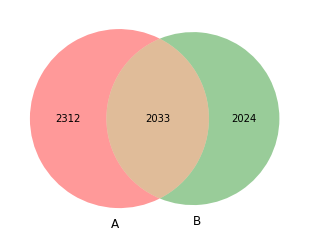

In [11]:
venn2([etcsl_words_s, lexical_words_s])

This basic plot is not too informative because it does not include the size of each set, nor its name. We can customize colors, size of the plot, and the legends. This customization is put in a function so it can be reused later on.

In [12]:
def plot_venn(lit_vocab, lex_vocab):
    """The function takes two sets and draws a Venn diagram that shows the intersection between the two sets.
    The legend includes the size of each set and the percentage of the intersection with the other set.
    """
    plt.figure(figsize=(8,8))
    lit_abs = len(lit_vocab)
    lex_abs = len(lex_vocab)
    inter_abs = len(lit_vocab.intersection(lex_vocab))
    lit_per = "{:.0%}".format(inter_abs/lit_abs)
    lex_per = "{:.0%}".format(inter_abs/lex_abs)
    lit_legend = "literary (" + str(lit_abs) + ') ' + lit_per + " overlap"
    lex_legend = "lexical (" + str(lex_abs) + ') ' + lex_per + " overlap"
    c = venn2([lit_vocab, lex_vocab], (lit_legend, lex_legend))
    c.get_patch_by_id('10').set_color("#fdb515")
    c.get_patch_by_id('01').set_color("#003262")
    c.get_patch_by_id('11').set_color("#bc9b6a")
    plt.show()
    return

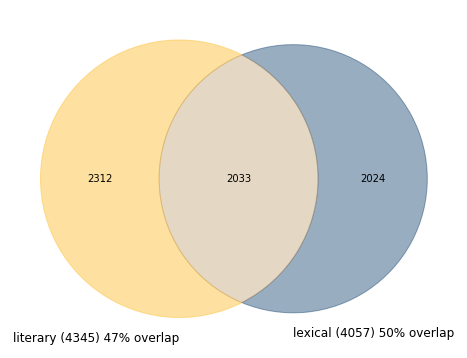

In [13]:
plot_venn(etcsl_words_s, lexical_words_s)

## 2 Second Approach: Multiple Word Expressions

Instead of looking at individual words (or lexemes), we may also look at lexical *entries* and their presence (or absence) in literary texts. The list of domestic animals, for instance, includes the entry `udu dijir-e gu₇-a`('sheep eaten by a god'), lemmatized as `udu[sheep]n diŋir[god]n gu[eat]v/t`. Unsurprisingly, all these very common lemmas appear in the literary corpus, and thus in our previous analysis this item results in three hits. But does the expression as a whole ever appear in the literary corpus? 

In order to perform the comparison on the lexical entry level we first need to represent our data (lexical and literary) as lines, rather than as individual words. Lines in lexical texts will become our unit of comparison. Lines in literary texts will serve as boundaries, since noun phrases do not usually continue from one line to the next.

### 2.1 Line by Line

The dataframe `lexical` that was produced in section 0.4 contains the lemmatizations of all Old Babylonian lexical texts in a word-by-word (or rather lemma-by-lemma) arrangement. In order to work with lexical *entries* we need to reconstruct lines. That is, we collect the words (lemmas) that belong to the same line of the same lexical text. The dataframe `lexical` includes the fields `id_text` and `id_line` that allow us to do so. We want to change a series of entries like this:

| id_text | id_line | lemma|
|:-------|:------|:------|
| dcclt/Q000001 |	1 | udu\[sheep\]n |
| dcclt/Q000001|	1 | niga\[fattened\]v/i|
| dcclt/Q000001|	2 |	udu\[sheep\]n|
| dcclt/Q000001|	2 |	niga\[fattened\]v/i|
| dcclt/Q000001|	2 |	sag\[rare\]v/i|

Into two entries (representing two lines in a lexical text) like this:

| id_text | id_line | lemma|
|:-------|:------|:------|
| dcclt/Q000001 |	1 | udu\[sheep\]n niga\[fattened\]v/i |
| dcclt/Q000001|	2 | udu\[sheep\]n niga\[fattened\]v/i sag\[rare\]v/i |

In order to do this we use the Pandas functions `groupby()` and `agg()` (for aggregate). The `groupby()` function takes as argument a list of fields on which the grouping should be performed, in this case the fields `id_text` and `id_line`. The `groupby()` function returns a so-called "GroupBy object" which preserves all the information of the original dataframe. The GroupBy object can be further manipulated with the `agg()` function.

The `agg()` function works on a GroupBy object and computes summary statistics (such as mean, sum, or average) for each group. In our case each group is a line in a lexical text and the "summary statistics" that we want is simply the concatenation of all the string values in the `lemma` column. The `agg()` function takes as argument a dictionary with field names as key and  functions as value. The function `' '.join` joins the strings in the `lemma` column and separates them by a space. A second field that is aggregated is `extent`. This field indicates (among other things) the number of broken or illegible lines between two lines of text. We will use that data in a later phase of the analyis.

The `agg()` function returns a new dataframe with a composite index. The Pandas function `reset_index()` will create a new (flat) index that starts counting from 0.

In [14]:
lexical = lexical.groupby([lexical['id_text'], lexical['id_line']]).agg({
        'lemma': ' '.join,
        'extent': ''.join
    }).reset_index()

In [15]:
lexical[:10]

,id_text,id_line,lemma,extent
0,dcclt/P117394,2,kid[mat]n,
1,dcclt/P117394,3,kid[mat]n andul[shade]n,
2,dcclt/P117394,4,kid[mat]n antadul[cloak]n,
3,dcclt/P117395,2,ŋešed[key]n,
4,dcclt/P117395,3,pakud[~tree]n,
5,dcclt/P117395,4,raba[clamp]n,
6,dcclt/P117396,2,hašhur[apple]n,
7,dcclt/P117396,3,hašhur[apple]n baza[dwarf]n,
8,dcclt/P117396,4,hašhur[apple]n mari[1]sn,
9,dcclt/P117397,2,laqipu[1]dn,


Now we do essentially the same for the `etcsl` dataframe, reconstructing lines in literary compositions.

In [16]:
etcsl = etcsl.groupby([etcsl['id_text'], etcsl['id_line'], etcsl['text_name']]).agg({
        'lemma': ' '.join,
        'extent': ''.join
    }).reset_index()

In [17]:
etcsl[1000:1010]

,id_text,id_line,text_name,lemma,extent
1000,c.1.1.3,51,Enki and the world order,x[na]na x[na]na x[na]na en[lord]n uŋ[people]n ...,
1001,c.1.1.3,52,Enki and the world order,aya[father]n enki[1]dn uŋ[people]n numun[seed]...,
1002,c.1.1.3,53,Enki and the world order,nudimmud[1]dn u[ewe]n zid[right]v/i ŋa₂[na]na ...,
1003,c.1.1.3,54,Enki and the world order,ab[cow]n numun[seed]n e[leave]v/i amar[young]n...,
1004,c.1.1.3,55,Enki and the world order,uzud[goat]n zid[right]v/i ŋa₂[na]na e[leave]v/...,
1005,c.1.1.3,56,Enki and the world order,gana[field]n gana[field]n zid[right]v/i ŋa₂[na...,
1006,c.1.1.3,57,Enki and the world order,gurudud[heap]n gurumaš[heap]n aneden[steppe]n ...,
1007,c.1.1.3,58,Enki and the world order,kalam[land]n ki[place]n tab[burn]v/t e[leave]v/i,
1008,c.1.1.3,60,Enki and the world order,x[na]na x[na]na,
1009,c.1.1.3,61,Enki and the world order,enki[1]dn lugal[king]n abzu[water]n ni[fear]n ...,


### 2.2 Extract lexical entries 
Each row in the resulting DataFrame `lexical` now consists of a text ID (`id_text`), a line number (`id_line`), and the lemmas that represent a lexical *entry* (e.g. `udu[sheep]n diŋir[god]n gu[eat]v/t`). We extract the `lemma` column, remove duplicate lexical entries with the `set()` function and create a `list`. Any entry that contains an unlemmatized word is useless for the comparison and is omitted by means of a list comprehension.

In [18]:
lex_vocab = list(set(lexical["lemma"]))
lex_vocab = [lemma for lemma in lex_vocab if not "[na]na" in lemma ]
lex_vocab[0:10]

['siki[hair]n igi[eye]n saŋ[choose]v/t',
 'ŋirtab[scorpion]cn',
 'e[house]n da[line]n',
 'ŋeš[tree]n gibil[sprout]n',
 'nundum[lip]n ana[upper]aj',
 'su[fibers]n ŋešnimbar[palm]n',
 'aŋarin[matrix]n sig[tie]v/t',
 'šaŋan[flask]n kuš[skin]n sig[put]v/t',
 'ayaya[grandfather]n',
 'lu[person]n lukiʾinimak[witness]n']

## 2.3 Mark lexical entries in literary texts
The list `lex_vocab` now contains all uniquely lemmatized entries in the Old Babylonian lexical corpus as edited in [DCCLT](http://oracc.org/dcclt). This is the vocabulary that we wish to find in the literary corpus as edited in [ETCSL](http://etcsl.orinst.ox.ac.uk/).

In order to do so we will first sort the list `lex_vocab` by string length, so that the longest item comes first. Item length is important here: the lemma sequence `udu[sheep]N niga[fattened]AJ sag[good]V/i` should be evaluated before `udu[sheep]N niga[fattened]AJ`. This is also the reason why we use a list rather than a set (which does not have an order). From this list we remove all entries that do not have a space (are not multiple-word entries). We now iterate through this list and search for identical sequences of lemmas in the `etcsl` dataframe. When found, those lemma sequences are connected with asterisks. At this point it is important that the `etcsl` dataframe still has the unlemmatized entries, that we will not accidentally match `gud[bull]n an[heaven]n` with `gud[bull]n x-ga[na]na an[heaven]n`.

We will use the Pandas function `str.replace()`. This function takes two arguments: the string to be replaced, and the replacement string. By default, the first argument of `str.replace()` uses [regular expressions](https://www.regular-expressions.info/), so that a string like `udu[sheep]n` is interpreted as "any string that begins with 'udu' followed by one of the characters in '\[sheep\]' followed by 'n'". This is obvioously not what we want (the search will most likely find zero matches). We can avoid this behaviour by "escaping" the special characters (preceding them with a backslash). The function `escape()` from the `re` (regular expression) library takes care of that.

Now we create a variable `replacewith` that is identical with the lexical item, but has its spaces replaced by asterisks. Finally we run the `str.,replace()`.

This process takes a considerable amount of time. It has to check each line in [ETCSL](http://etcsl.orinst.ox.ac.uk/) (almost 36.500 lines) against thousands of lexical entries. The progress bar (form the `tqdm` library) follows the progress through the list of lexical entries.

The `lemma` column of the `etcsl` dataframe will now represent the [ETCSL](http://etcsl.orinst.ox.ac.uk/) data in a line-by-line presentation of lemmatizations, with asterisks connecting lemmas if a corresponding sequence of lemmas exists as a lexical entry.

In [19]:
lex_vocab.sort(key=len, reverse=True)
multiple_word = [entry for entry in lex_vocab if " " in entry]
for item in tqdm.tqdm(multiple_word):
    findwhat = re.escape(item)
    replacewith = item.replace(" ", "*")
    etcsl["lemma"] = etcsl["lemma"].str.replace(findwhat, replacewith)

100%|██████████████████████████████████████| 5952/5952 [03:43<00:00, 26.65it/s]


Now replace all spaces with asterisks in the list lex_vocab, so that the multiple-word entries are represented in the same way as the are in the literary corpus.

In [20]:
lex_vocab = [lemma.replace(" ", "*") for lemma in lex_vocab]

Now we create the two sets necessary for the Venn diagram. The `lemma` column of the `etcsl` dataframe represents lines of text - we need to split those lines into individual lemmas and lemma sequences (the lemma sequences connected by asterisks). An efficient way of doing that is to join all the strings in the `lemma` column into one giant string (separating the individual lines by spaces) with the command `" ".join()`. We can then split this string again with the `split()` command - by default `split()` will split a string at each white space. The function returns a list. After turning this list into a set we can remove all the non-lemmatized words from the [ETCSL](http://etcsl.orinst.ox.ac.uk) data set with a set comprehension.

In [25]:
etcsl_words2 = ' '.join(etcsl["lemma"])
etcsl_words_s2 = set(etcsl_words2.split())
etcsl_words_s2 = {lemma for lemma in etcsl_words_s2 if not '[na]na' in lemma}
lexical_words_s2 = set(lex_vocab)

We can now reuse the function `plot_venn` that was created above.

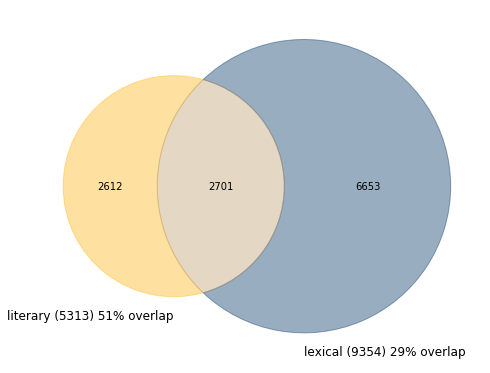

In [26]:
plot_venn(etcsl_words_s2, lexical_words_s2)

# Add them Up
### this needs a better explanation to be placed after the plot. Refer to the numbers in a more general sense, because they change whenever DCCLT changes
By creating the union of the two sets (the set with individual words and the set with the lexical entries) we get the most complete comparison of the two corpora. Here `gud[oxen]N*an[heaven]N`, `gud[oxen]N` and `an[heaven]N` are all counted as entries, whether or not `gud` and `an` actually appear as such in the lexical corpus.

In [23]:
etcsl_words_s3 = etcsl_words_s | etcsl_words_s2
lexical_words_s3 = lexical_words_s | lexical_words_s2

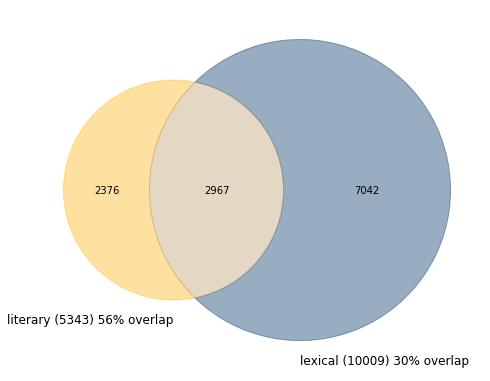

In [28]:
plot_venn(etcsl_words_s3, lexical_words_s3)

# Discussion
Whereas the change from individual *words* to *lexical expressions* made a big difference in the plot, adding the two up changes the picture only slightly. Many words (lemmas) are part of lexical entries, but are also lexical entries in and of themselves. These individual words are already included in the set of lexical entries and are taken into account in the previous plot. Nevertheless, there are several hundreds of words added on the lexical side - these are lexemes that *only* appear in multiple-word lexical entries and are not attested in the lexical corpus as separate words. 

On the literary side the number of additional entries is much smaller (counted in the tens, rather than in the hundreds). These are words that appear *only* in fixed expressions (connected by \*), but not as separate words. We can see which words those are by by subtracting the set `etcsl_words_s2` from `etcsl_words_s3`.

In [29]:
etcsl_words_s3 - etcsl_words_s2

{'ašgar[kid]n',
 'bazbaz[bird]n',
 'bur[grass]n',
 'burgia[offering]n',
 'ebgal[oval]n',
 'ebir[vessel-stand]n',
 'giʾiziʾešta[~bread]n',
 'guʾeguʾe[fatty?]aj',
 'hub[cvve]v/t',
 'huz[cvve]v/t',
 'kašu[~plow]n',
 'kiʾuš[waste]n',
 'ligidba[plant]n',
 'lillan[grain]n',
 'manzila[foot]n',
 'mer[cvve]v/t',
 'mur[noise]n',
 'namaʾa[unmng]n',
 'namniŋir[herald]n',
 'nim[high]v/i',
 'sa.ku[arm]n',
 'saharŋar[silt]n',
 'sala[bug-ridden]aj',
 'tuhul[hip]n',
 'tutu[cvve]v/t',
 'u[cvne]n',
 'ugudili[scalp]n',
 'uzudirig[mushroom]n',
 'zana[doll]n',
 'še[cone]n'}

The word `ašgar[kid]n`, for instance, appears only once in the ETCSL corpus, in the Gudea cylinders. 

In [36]:
etcsl[etcsl['lemma'].str.contains("ašgar\[kid\]n")]

,id_text,id_line,text_name,lemma,extent
10955,c.2.1.7,203,The building of Ninŋirsu's temple (Gudea cylin...,ašgar[kid]n*ŋeš[penis]n*zu[know]v/t kuš[skin]n...,


The context is a ritual where Gudea uses a virgin female kid (`ašgar ŋeš nu-zu`). This expression appears as a whole in the Old Babylonian list of domestic animals - as a result the word `ašgar` alone was not represented in the set `etcsl_words_s2`.

For the big picture, however, the last two graphs are very similar to each other and show that on the *literary* side, a little more than half of the vocabulary is attested in (contemporary) lexical texts. On the *lexical* side, however, there appears to be a large group of words and expressions (around 70%) that were taught to students but were not used anywhere in the literary tradition.

# The End
Everything below is still in the trial and error phase.

In [ ]:
etcsl

# Create a Corpus
The etcsl dataframe is organized by line. The `aggregate` function assembles the lines that belong to a single composition. The resulting dataframe has 394 entries, one for each composition. 

In [ ]:
corpus = etcsl.groupby(
    [etcsl["id_text"], etcsl["text_name"]]).aggregate(
    {"lemma": " ".join}).reset_index()

# Document Term Matrix
The corpus is transformed into a Document Term Matrix (or DTM) in which each word (or expression) is a column and each row a Sumerian composition. The lexical vocabulary is used as a filter (only words that appear in the lexical texts are allowed in the DTM).

First sort the lexical vocabulary alphabetically.

Use CountVectorizer (from Sklearn) to initiate the DTM. The `token_pattern` indicates what a word looks like and what signals the end of a word. In modern corpora this can be fairly complex (including spaces, commas, full stops, etc.) but in the current corpus a space will always separate one token from the next. The regex `r'[^ ]+'` means "any sequence of characters, except space".

Transform the DTM to a dataframe.

NB a DTM is not necessary for the raw comparison/Venn diagram - only for further inspection.

In [ ]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+', binary = False, vocabulary=lex_vocab)
etcsl_dtm = cv.fit_transform(corpus['lemma'])
#etcsl_df = pd.DataFrame(etcsl_dtm.toarray(), columns= cv.get_feature_names(), index=corpus["etcsl_no"])
etcsl_df = pd.DataFrame(etcsl_dtm.toarray(), columns= lex_vocab, index=corpus["id_text"])

In [ ]:
etcsl_df

# Words in Lexical Texts not in ETCSL
If a word or expression in the lexical corpus is never used in the literary texts from [ETCSL](http://etcsl.orinst.ox.ac.uk/) the sum of its column will be `0`.

Give the number of columns (the number of unique words and expressions in the lexical texts), the number of words/expressions never used in the ETCSL corpus and the relation between those two numbers in percent.

In [ ]:
lex_not_in_etcsl = etcsl_df.loc[:, etcsl_df.sum()==0]
len(etcsl_df.columns), len(lex_not_in_etcsl.columns), str(len(lex_not_in_etcsl.columns)/len(etcsl_df.columns)*100) + "%"

# Simplify
The above may be an overly complex way of doing it.
Alternative: make a full dtm of etcsl (without a vocabulary constraint); make the etcsl vocabulary and lexical vocabulary into sets that can be subtracted from each other.

In [ ]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+', binary = False)
etcsl2_dtm = cv.fit_transform(corpus['text'])
etcsl2_df = pd.DataFrame(etcsl2_dtm.toarray(), columns= cv.get_feature_names(), index=corpus["etcsl_no"])
etcsl_vocab_s = set(etcsl2_df.columns)
lex_vocab_s = set(lex_vocab)
diff_e_l = list(etcsl_vocab_s - lex_vocab_s)
diff_l_e = list(lex_vocab_s - etcsl_vocab_s)

In [ ]:
print("number of words/expressions in ETCSL " + str(len(etcsl_vocab_s)))
print("number of words/expressions in lexical texts " + str(len(lex_vocab_s)))
print("number of words/expressions in ETCSL not in lexical " + str(len(diff_e_l)))
print("number of words/expressions in lexical not in ETCSL " + str(len(diff_l_e)))

In [ ]:
plt.figure(figsize=(4,4))
venn2([etcsl_vocab_s, lex_vocab_s], ("literary", "lexical"))
plt.show()

# Rare Words Shared by Lex and Lit
Which words appear in Lex and in Lit but appear only once in Lit? In which composition do we find such words; which words are those?

First create a dataframe (`rare`) that only has the columns that add up to `1` (word or expression appears only once in the corpus). The row totals of this dataframe indicate per composition (= row) how many such rare words they contain. These row totals are added as a separate column. The composition naes are extracted from the `corpus` dataframe created above. Finally the dataframe is sorted by the row totals.

The dataframe `rare` includes columns for each of the words that appear only once. We are showing only the columns that identify the composition and the row totals.

In [ ]:
rare =etcsl_df.loc[:, etcsl_df.sum()==1].reset_index()
rare["no. of unique lexical correspondences"] = rare.sum(axis=1)
rare["text_name"] = corpus["text_name"]
rare = rare.sort_values('no. of unique lexical correspondences', ascending = False)
rare.loc[:,["etcsl_no", "no. of unique lexical correspondences", "text_name"]]

# Which Words?
Which are the rare words that define this list of compositions? We first extract the full list of words from the column names of the daraframe `rare`. The variable `words` is a Numpy array that contains strings.

In [ ]:
words = rare.columns.values
len(words)

# The rare words in the top-ten
The first ten compositions in our list are the ones that have the most rare words shared with lexical texts. Each row, representing a composition, has columns that represent individual words. We create a `mask` (a sequence of boolean values `True` or `False`) that indicate whether or not the value in the column is 1. If the boolean is `True` the word is printed.

In [ ]:
for i in range(10):
    indexes = rare.iloc[i] == 1
    print(rare.iloc[i,-1]), print(words[indexes])

In [ ]:
lexical["text"] = lexical["text"].str.replace(" ", "*")
lexical

In [ ]:
lexical_corpus = lexical.groupby([lexical["id_text"], 
                                  lexical["text_name"]]).aggregate({"text": " ".join}).reset_index()
lexical_corpus

### 2.1 Select Lexical Compositions
Select the following compositions: 
* Ura 1 dcclt/Q000039
* Ura 2 dcclt/Q000040
* Ura 3 dcclt/Q000001
* Ura 4 dcclt/Q000041
* Ura 5 dcclt/Q000042
* Ura 6 dcclt/Q000043
* Lu₂-Azlag₂ B/C Q000302 
* Ugumu dcclt/Q000268
* Diri dcclt/Q000057
* Nigga dcclt/Q000052
* Izi dcclt/Q000050
* Kagal dcclt/Q000048
* Lu dcclt/Q000047


In [ ]:
keep = ["dcclt/Q000039", 
    "dcclt/Q000040",
    "dcclt/Q000001",
    "dcclt/Q000041",
    "dcclt/Q000042",
    "dcclt/Q000043",
    "dcclt/Q000302 ",
    "dcclt/Q000268",
    "dcclt/Q000057",
    "dcclt/Q000052",
    "dcclt/Q000050",
    "dcclt/Q000048",
    "dcclt/Q000047"]
lexical = lexical.loc[lexical["id_text"].isin(keep)]

In [ ]:
lexical_temp = lexical[["id_text", "id_line", "lemma"]]

In [ ]:
lexical_temp[lexical_temp["id_text"]=="dcclt/Q000001"]

In [ ]:
lexical = lexical.groupby([lexical['id_text'], lexical['id_line']]).agg({
        'lemma': ' '.join,
        'extent': ''.join
    })

In [ ]:
lexical

In [6]:
from scipy import spatial

In [7]:
dataSetI = [1, 1, 0, 1]
dataSetII = [1, 0, 1, 1]
result = 1 - spatial.distance.cosine(dataSetI, dataSetII)

In [8]:
result

0.6666666666666666